## Federated Learning Tutorial: Create Secure Federation via Globus [Client 1]


<img src="https://appfl.ai/en/latest/_static/appfl-globus.png" width="40%" alt="APPFL Logo">


In this tutorial, we will leverage the Advanced Privacy-Preserving Federated Learning ([APPFL](https://github.com/APPFL/APPFL)) framework to launch a federated learning server for orchestrating federated learning experiments between two distributed clients **within a secure federated enabled by Globus**. A secure federation is a **Globus Group** created by the server, with trusted clients invited via their institutional emails. 


### Dataset

In this example, we will be working on the Fed-IXI dataset from [FLamby](https://arxiv.org/pdf/2210.04620), which contains brain T1 magnetic resonance images (MRIs) from 3 hospitals. The statistics of the data from three hospitals are as follows. The data from each hospital are randomly split into a training set (80% of data) and a test set (20% of data). **This notebook represents the Hammersmith Hospital (HH).**

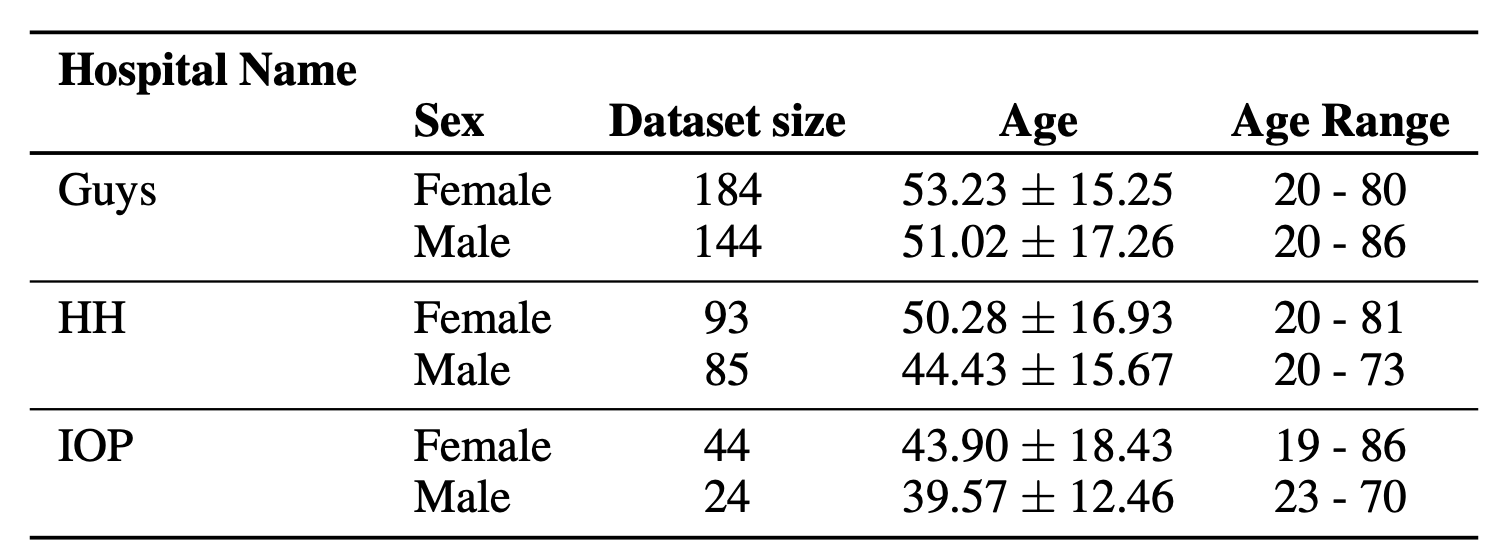


### Training Goal

In this example, all the MRIs are preprocessed to get sized to 48×60×48 voxels. The training goal is to segment the pixels from other head components, such as eyes, skin, and fat. To do supervised training, the corresponding brain image binary segmentation masks are given are labels. 

### Training Loss

In this example, we use **Dice Loss**, a loss function commonly used in **image segmentation tasks**, particularly in **medical imaging**. It is based on the **Dice Similarity Coefficient (DSC)**, which measures the overlap between predicted and ground truth segmentation masks.

**Dice Coefficient Formula:**

$$
\text{Dice}(P, G) = \frac{2|P \cap G|}{|P| + |G|} = \frac{2 \sum_i p_i g_i}{\sum_i p_i + \sum_i g_i}
$$

- $P$: predicted binary mask  
- $G$: ground truth binary mask  
- $p_i, g_i \in \{0, 1\}$

**Dice Loss:**

$$
\text{Dice Loss} = 1 - \text{Dice}(P, G)
$$

For numerical stability (to avoid division by zero), a small epsilon is often added:

$$
\text{Dice Loss} = 1 - \frac{2 \sum_i p_i g_i + \epsilon}{\sum_i p_i + \sum_i g_i + \epsilon}
$$

### Training Settings

We use a [UNet](https://arxiv.org/pdf/1505.04597) model taking the individual T1 image as input, to predict the associated binary brain mask. The UNet model is a standard type of convolution neural network architecture commonly used in biomedical image segmentation tasks. It is specifically used to perform semantic segmentation, meaning that each voxel of the image volume is classified. 

The UNet is optimized with a batch size of 2 and a learning rate of $10^{−3}$ with the AdamW optimizer.

In [ ]:
# [WARNING]: Please only run this cell ONCE at the beginning of your script.
# First: Change the working directory to the root of the repository and ignore warnings
import os
import warnings

os.chdir("../..")
warnings.filterwarnings("ignore")

### 1. Introduction to Federated Learning

As shown in the figure below, federated learning can be understood as a distributed version of traditional machine by iterating the following two steps after a model initialization step

(1) Each client trains an ML model using its local dataset and submits the updated model to the server.

(2) The server aggregates these local models to update the global model and then sends it back to the clients for further local training.

As only model parameters are exchanged, federated learning offers a promising solution to utilize data from multiple data owners without direct data sharing, and it can usually help with training more robust, generalized, and powerful model by leveraging more training data.

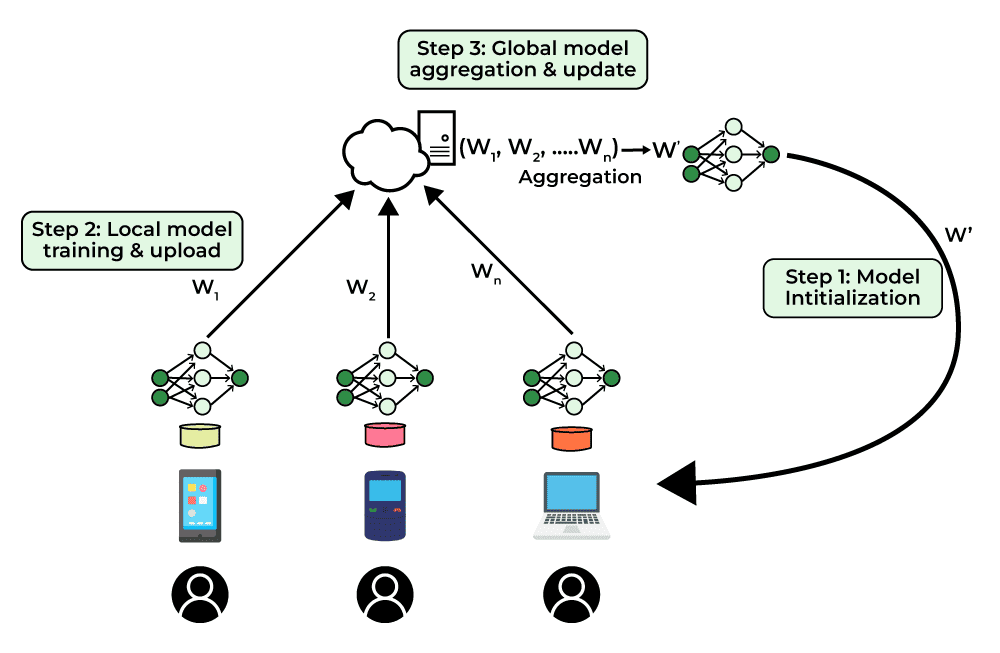

### 2. Globus Authentication

Now, we need to do globus authentication for the client by running the following cell.

After running the cell, a popup input box will first prompt to ask whether you want to login for FL server or FL client. Select 1 if you will take the server role for the FL experiment, and 2 if you will be one of the clients. **Enter 2 for this case.**

When you need to login to your Globus account, you will be provided a web link where you can login to Globus and get an authentication code. Copy the code and enter it in the popup input box.

If you have already logged in as an FL client, you can either logout (Option 1), change to another account (Option 2), or do nothing (Option 3).

**Below shows an example login workflow.**

```bash
Please select whether you are authenticating for the federated learning server or client (Enter 1 or 2)
-------------------------------------------------------------------------------------------------------
1. Federated learning server
2. Federated learning client
-------------------------------------------------------------------------------------------------------
2
You have already logged in as a federated learning client
You can either logout (1), change to another account (2), or just exit (3)
-------------------------------------------------------------------------------------------------------
1. Logout
2. Change to another account
3. Exit
-------------------------------------------------------------------------------------------------------
2
Please authenticate with Globus here
------------------------------------
https://auth.globus.org/v2/oauth2/authorize?client_id=...
------------------------------------

Please enter the authorization code you get after login here: PLEASE_ENTER_YOUR_AUTH_CODE
-------------------------------------------------------------------------------------------------------
```

In [ ]:
from appfl.login_manager.globus import appfl_globus_auth

appfl_globus_auth()

### 3. Create federated learning client agent from configurations

In the client configurations, it has four main parts:

- `client_id`: A unique identifier for the client
- `train_configs`: Client-specific training related configurations, such as the device and logging directories
- `data_configs`: Information about the dataloader file that can create a PyTorch dataset for the IXI data
- `comm_configs`: Information needed to connect to the server notebook

In [ ]:
from omegaconf import OmegaConf

client_agent_config = OmegaConf.load("./resources/configs/flamby/ixi/client_1.yaml")
print("==========Client Configuration==========")
print(OmegaConf.to_yaml(client_agent_config))
print("========================================")

For `comm_configs`, we need to update it to make sure it can securely connect with the server. **Please pay attention to the following fields before running the cell**.

- `server_uri`: This is the URI you got from the server notebook.
- `root_certificate`: This is the path where the client stores the CA certificate shared by the server.

In [ ]:
import pathlib
from appfl.agent import ClientAgent

# Reminder: Replace this with the URI you got from the server notebook!
client_agent_config.comm_configs.grpc_configs.server_uri = (
    "128.55.64.49:50051"  # YOU NEED TO CHANGE THIS!
)
client_agent_config.comm_configs.grpc_configs.use_ssl = True
# Reminder: Make sure the path to the CA certificate is correct!
client_agent_config.comm_configs.grpc_configs.root_certificate = os.path.join(
    pathlib.Path.home(), ".appfl/ssl/ca.crt"
)  # YOU MIGHT NEED TO CHANGE THIS!
client_agent_config.comm_configs.grpc_configs.use_authenticator = True
client_agent_config.comm_configs.grpc_configs.authenticator = "GlobusAuthenticator"
client_agent_config.comm_configs.grpc_configs.authenticator_args = OmegaConf.create(
    {"is_fl_server": False}
)

client_agent = ClientAgent(client_agent_config=client_agent_config)

### 4. Create Client Communicator

Now, we create a grpc client communicator for **securely** sending various requests to the server.

In [ ]:
from appfl.comm.grpc import GRPCClientCommunicator

client_communicator = GRPCClientCommunicator(
    client_id=client_agent.get_id(),
    **client_agent_config.comm_configs.grpc_configs,
)

### 5. Start training loop by sending requests to server.

In this main training loop, it has four main types of request to send to the server:

(1) `get_configuration()`: Get general client configurations for local training

(2) `get_global_model(init_model=True)`: Get the initial global model for training

(3) `update_global_model()`: Send the trained local model to update the global model, and get the updated model back for further local training

(4) `invoke_custom_action(action="close_connection")`: Close the connection with the server

In [ ]:
# Get general client configurations
client_config = client_communicator.get_configuration()
client_agent.load_config(client_config)

# Get initial global model parameters
init_global_model = client_communicator.get_global_model(init_model=True)
client_agent.load_parameters(init_global_model)

# Start local training loop
while True:
    client_agent.train()
    local_model, metadata = client_agent.get_parameters()
    new_global_model, metadata = client_communicator.update_global_model(
        local_model, **metadata
    )
    if metadata["status"] == "DONE":
        break
    client_agent.load_parameters(new_global_model)

# Close connection
client_communicator.invoke_custom_action(action="close_connection")